#Module

In [1]:
from Bio import SeqIO
import pandas as pd
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Fungsi untuk menghasilkan K-mers dengan panjang 3 dari urutan DNA
def get_kmers(sequence, k=3):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Fungsi untuk membuat mapping manual dari K-mers ke angka
def create_kmer_mapping(kmers_list):
    unique_kmers = set([kmer for kmers in kmers_list for kmer in kmers])
    kmer_to_index = {kmer: idx + 1 for idx, kmer in enumerate(unique_kmers)}
    return kmer_to_index

# Fungsi untuk mengonversi K-mers ke angka berdasarkan mapping
def map_kmers_to_indices(kmers, kmer_mapping):
    return [kmer_mapping[kmer] for kmer in kmers]

In [4]:
df = pd.read_excel("../Dataset/Dataset_Preprocess_No-Sampling.xlsx")
df = df[['urutan', 'kelas']]

In [5]:
df

,urutan,kelas
0,AGTTGTTAGTCTACGTGGACCGACAAAGACAGATTCTTTGAGGGAG...,0
1,AGTTGTTAGTCTACGTGGACCGACAAGAACAGTTTCGAATCGGAAG...,0
2,GTGGACCGCAAAGAACAGTTTCGAATCGGAAGCTTGCTTAACGTAG...,0
3,TTTCATTTTACCACACGTAACGGAGAACCACACATGATCGTCGGTA...,0
4,ATGAATAACCAACGAAAAAATGCGAGAAAAACGCCTTTCAATATGC...,0
...,...,...
1928,ATGAATAACCAACGGAAAAAGGCGAAAAACACGCCTTTCAATATGC...,1
1929,ATGAATAACCAACGGAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1
1930,ATGAACAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1
1931,ATGAATAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1


In [6]:
df['kmers'] = df['urutan'].apply(lambda x: get_kmers(x, 3))
df

,urutan,kelas,kmers
0,AGTTGTTAGTCTACGTGGACCGACAAAGACAGATTCTTTGAGGGAG...,0,"[AGT, GTT, TTG, TGT, GTT, TTA, TAG, AGT, GTC, ..."
1,AGTTGTTAGTCTACGTGGACCGACAAGAACAGTTTCGAATCGGAAG...,0,"[AGT, GTT, TTG, TGT, GTT, TTA, TAG, AGT, GTC, ..."
2,GTGGACCGCAAAGAACAGTTTCGAATCGGAAGCTTGCTTAACGTAG...,0,"[GTG, TGG, GGA, GAC, ACC, CCG, CGC, GCA, CAA, ..."
3,TTTCATTTTACCACACGTAACGGAGAACCACACATGATCGTCGGTA...,0,"[TTT, TTC, TCA, CAT, ATT, TTT, TTT, TTA, TAC, ..."
4,ATGAATAACCAACGAAAAAATGCGAGAAAAACGCCTTTCAATATGC...,0,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ..."
...,...,...,...
1928,ATGAATAACCAACGGAAAAAGGCGAAAAACACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ..."
1929,ATGAATAACCAACGGAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ..."
1930,ATGAACAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAC, ACA, CAA, AAC, ACC, CCA, ..."
1931,ATGAATAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ..."


TF-IDF

In [7]:
df['kmers_str'] = df['kmers'].apply(lambda x: ' '.join(x))

Memangkas yang panjang menjadi 145 - karena terpendeknya 145

In [8]:
def truncate_to_length(kmers_str, target_length=145):
    return kmers_str[:target_length]

df['kmers_str_adjusted'] = df['kmers_str'].apply(truncate_to_length)


In [9]:
vectorizer = TfidfVectorizer()

X - y

In [10]:
X = vectorizer.fit_transform(df['kmers_str_adjusted'])
y = df['kelas'].values


print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1933, 64)
Shape of y: (1933,)


In [11]:
X_array = X.toarray()
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X_array, columns=feature_names)

tfidf_df

,aaa,aac,aag,aat,aca,acc,acg,act,aga,agc,...,tcg,tct,tga,tgc,tgg,tgt,tta,ttc,ttg,ttt
0,0.136239,0.000000,0.140118,0.000000,0.219612,0.180184,0.159316,0.0,0.201738,0.000000,...,0.000000,0.332258,0.000000,0.000000,0.111082,0.137511,0.184241,0.118793,0.113255,0.000000
1,0.000000,0.108312,0.140805,0.000000,0.220690,0.181068,0.160098,0.0,0.101364,0.000000,...,0.155804,0.166944,0.000000,0.000000,0.111627,0.138186,0.185145,0.119376,0.113810,0.129180
2,0.140060,0.110806,0.288096,0.134625,0.112886,0.185238,0.000000,0.0,0.103698,0.169042,...,0.318784,0.000000,0.000000,0.124662,0.114197,0.000000,0.000000,0.122125,0.116431,0.132155
3,0.000000,0.150380,0.000000,0.000000,0.229803,0.251393,0.222278,0.0,0.070366,0.000000,...,0.000000,0.000000,0.104489,0.000000,0.000000,0.000000,0.128527,0.082870,0.000000,0.269029
4,0.701620,0.237889,0.000000,0.192683,0.000000,0.132562,0.234418,0.0,0.074209,0.000000,...,0.000000,0.000000,0.110196,0.089212,0.000000,0.000000,0.000000,0.000000,0.000000,0.094574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,0.646523,0.255743,0.110822,0.103572,0.086847,0.142511,0.252011,0.0,0.000000,0.000000,...,0.000000,0.000000,0.118466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101672
1929,0.381698,0.201316,0.261710,0.122295,0.000000,0.168272,0.297567,0.0,0.094201,0.000000,...,0.000000,0.000000,0.139881,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120051
1930,0.475648,0.282226,0.244595,0.000000,0.095841,0.157268,0.278107,0.0,0.088040,0.000000,...,0.000000,0.000000,0.130733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112200
1931,0.482659,0.190924,0.248200,0.115982,0.000000,0.159586,0.282207,0.0,0.089338,0.000000,...,0.000000,0.000000,0.132660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.113854


In [12]:
# Membagi data menjadi training dan testing set dengan rasio 80:20
X_train, X_test, y_train, y_test = train_test_split(X_array, y, test_size=0.2, random_state=42)

# Print shapes dari data yang sudah di-split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1546, 64)
Shape of X_test: (387, 64)
Shape of y_train: (1546,)
Shape of y_test: (387,)


In [13]:
from GCallbacks import PlotLosses, checkpoint_callback, TimeHistory, PlotTimes

# Inisialisasi callback
plot_losses_callback = PlotLosses()
time_callback = TimeHistory()
plot_times_callback = PlotTimes(time_callback)
call = [plot_losses_callback, time_callback, plot_times_callback, checkpoint_callback]

In [14]:
optimizer = Adam(learning_rate=0.01)

model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], 1))) 
model.add(Dense(1, activation='sigmoid'))

# Kompilasi model dengan optimizer Adam yang sudah diatur learning rate-nya
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [15]:
# Melatih model
history = model.fit(X_train, y_train, epochs=70, batch_size=32, validation_data=(X_test, y_test), callbacks=call)

Epoch 1/70
49/49 [==============================] - 4s 22ms/step - loss: 0.6456 - accuracy: 0.6695 - val_loss: 0.6337 - val_accuracy: 0.6667
Epoch 2/70
49/49 [==============================] - 1s 15ms/step - loss: 0.6224 - accuracy: 0.6772 - val_loss: 0.6107 - val_accuracy: 0.6667
Epoch 3/70
49/49 [==============================] - 1s 15ms/step - loss: 0.5644 - accuracy: 0.6714 - val_loss: 0.4984 - val_accuracy: 0.6512
Epoch 4/70
49/49 [==============================] - 1s 15ms/step - loss: 0.5320 - accuracy: 0.7316 - val_loss: 0.5137 - val_accuracy: 0.7494
Epoch 5/70
49/49 [==============================] - 1s 20ms/step - loss: 0.4319 - accuracy: 0.7801 - val_loss: 0.3791 - val_accuracy: 0.7959
Epoch 6/70
49/49 [==============================] - 1s 15ms/step - loss: 0.3446 - accuracy: 0.8499 - val_loss: 0.2956 - val_accuracy: 0.8708
Epoch 7/70
49/49 [==============================] - 1s 15ms/step - loss: 0.5845 - accuracy: 0.7038 - val_loss: 0.5521 - val_accuracy: 0.6744
Epoch 8/70
49

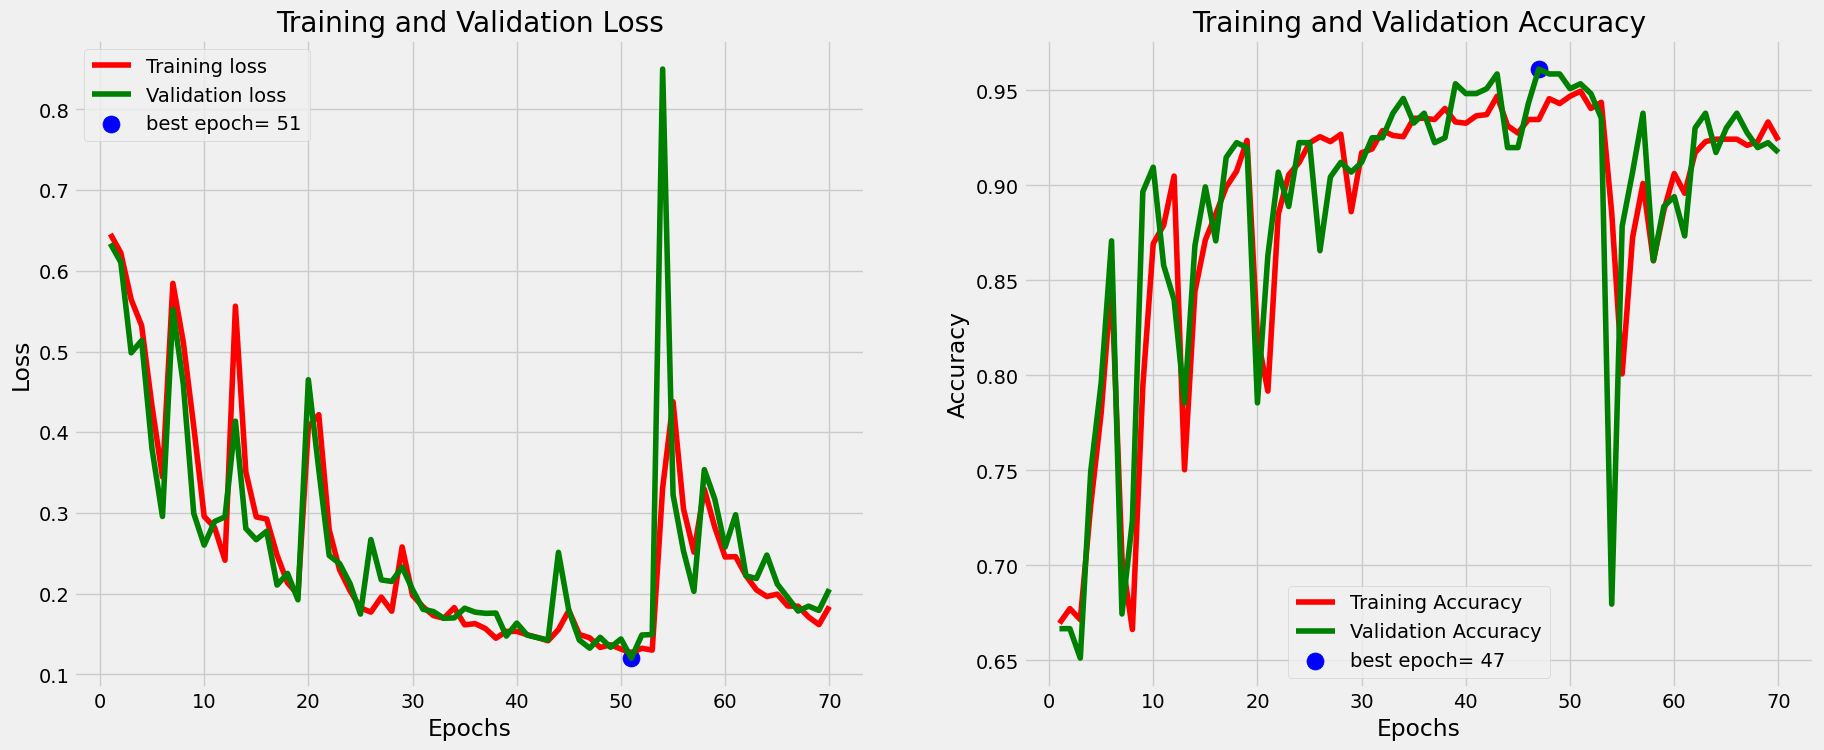

In [17]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [18]:
# Muat bobot dari file HDF5
model.load_weights('Checkpoints/model_epoch_47.h5')

In [19]:
y_pred_prob = model.predict(X_test)

y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

13/13 [==============================] - 0s 5ms/step
Accuracy: 0.96
Precision: 0.91
Recall: 0.98
F1-Score: 0.94


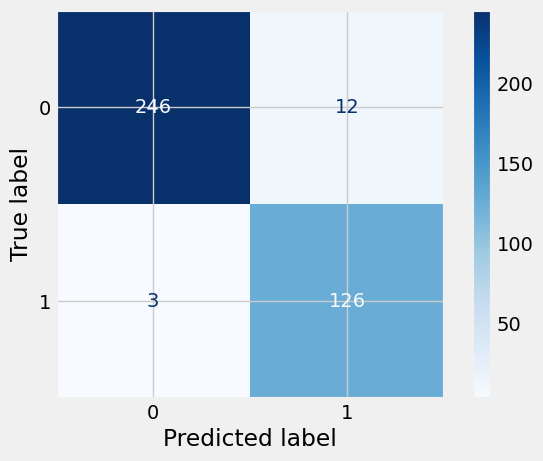

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()